### Deep Learning Course

2021/2022
***
Gonçalo Faria, André Martins
***
# Principal Component Analysis and Autoencoders

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

### Question 1.8

We will implement PCA with the following training data:

$\mathbf{x} =\begin{bmatrix} 1, 0, 1, 0 \end{bmatrix}$
$
\mathbf{x}^{(1)}=\begin{bmatrix}
2.5\\
2.4\\
\end{bmatrix}, \quad \mathbf{x}^{(2)}=\begin{bmatrix}
0.5\\
0.7\\
\end{bmatrix}, \quad \mathbf{x}^{(3)}=\begin{bmatrix}
2.2\\
2.9\\
\end{bmatrix}, \quad \mathbf{x}^{(4)}=\begin{bmatrix}
1.9\\
2.2\\
\end{bmatrix}
$

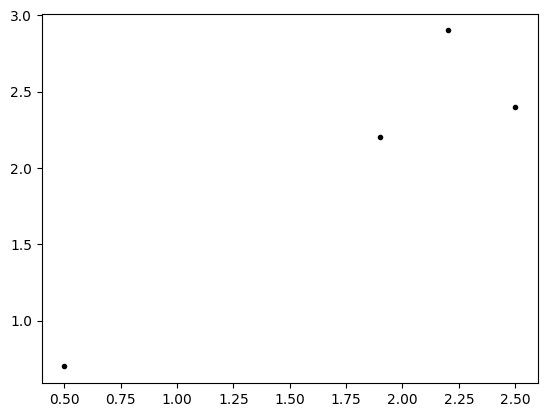

In [2]:
X = np.array([[2.5,2.4],[ 0.5, 0.7],[2.2, 2.9],[1.9,2.2]])

plt.plot(X[:, 0], X[:, 1], 'k.')
plt.show()

❓ Compute the covariance matrix and eigenvectors from the data

In [3]:
X = np.array([[2.5,2.4],[ 0.5, 0.7],[2.2, 2.9],[1.9,2.2]])

# compute the covariance matrix C

mu_X = np.mean(X,axis=0)

Z = (X - mu_X)

C = Z.T @ Z

# compute the eigenvalues and eigenvectors 
## HINT: use the function from np.linalg : `np.linalg.eig()'

eigen_value, eigen_vector = np.linalg.eig(C)

print(eigen_value,eigen_vector)


[0.15753176 4.87996824] [[-0.73229984 -0.68098233]
 [ 0.68098233 -0.73229984]]


❓ What is the first principal component? 

In [4]:
# get the principal component
max_component = np.argmax(eigen_value)

principal_component = np.expand_dims(
    eigen_vector[:,max_component],
    axis=0
)

print(max_component)
print(principal_component)

1
[[-0.68098233 -0.73229984]]


❓ Reduce the dimensionality of the training data by mapping the points onto the principal component

❓ Find the orthogonal projection of the data onto the first principal component’s subspace in the original coordinates.

In [5]:
#orthogonal projection
P = principal_component.T @ principal_component
P_X = X @ P
print("P_X = ",P_X)
Y = X @ principal_component.T
print("Y = ",Y)

P_X =  [[2.35618216 2.53373949]
 [0.58094675 0.62472577]
 [2.46640271 2.65226604]
 [1.97820335 2.12727692]]
Y =  [[-3.45997546]
 [-0.85310106]
 [-3.62183068]
 [-2.90492609]]


❓ What is the mean squared error of the projected training data?

In [6]:
MSE = np.sum( 
    ( P_X - X )**2 
) /4

print(f" MSE : {MSE}")

 MSE : 0.04863383382534045


Now let's plot everything

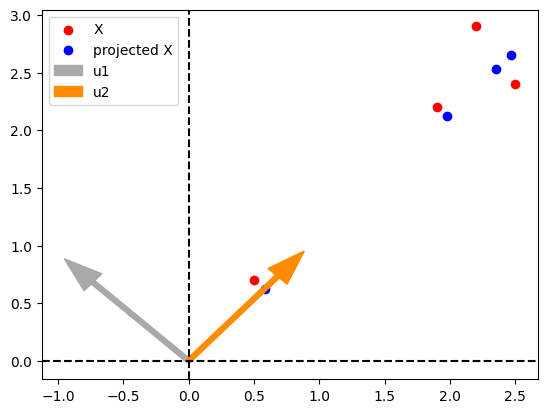

In [7]:
# plot
# data scatter
plt.scatter(X[:,0],X[:,1],color="red", label="X")

# projected scatter
plt.scatter(P_X[:,0],P_X[:,1],color="blue", label="projected X")


plt.arrow(0,0,eigen_vector[0,0],eigen_vector[1,0],
          head_width=0.2,width=0.04,head_length=0.3, color="darkgrey", label="u1")

plt.arrow(0,0, -eigen_vector[0,1], -eigen_vector[1,1],
          head_width=0.2,width=0.04,head_length=0.3, color="darkorange", label="u2")

# axis and legend
plt.axhline(0,color="black", linestyle="--")
plt.axvline(0,color="black", linestyle="--")
plt.legend()
plt.show()

### Applications : Image Denoising
Loading digits data and corrupting them with gaussian noise.

In [8]:
# Loading data and applying gaussian noise. 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_digits
data = load_digits()

X, y = data.data, data.target
# normalize images.
X = MinMaxScaler().fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1697, test_size=100
)

## applying gaussian noise
rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)

X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

Displaying the corrupted and uncorrupted images. 

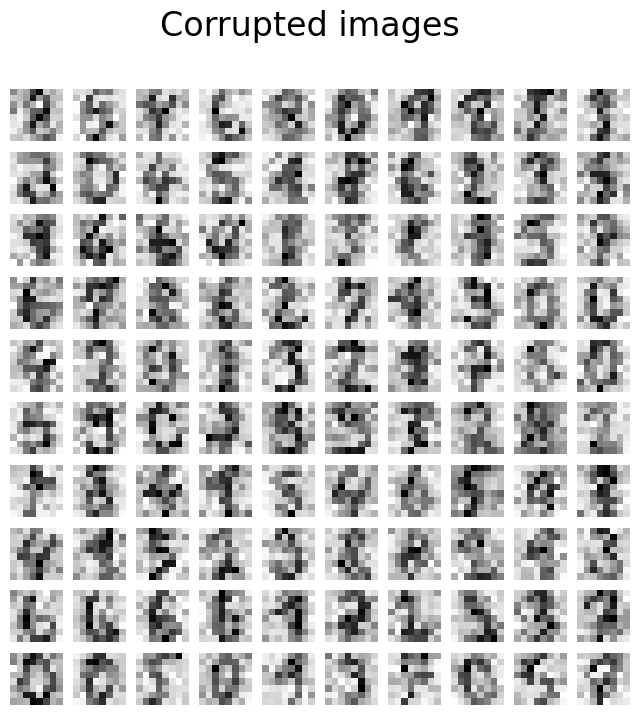

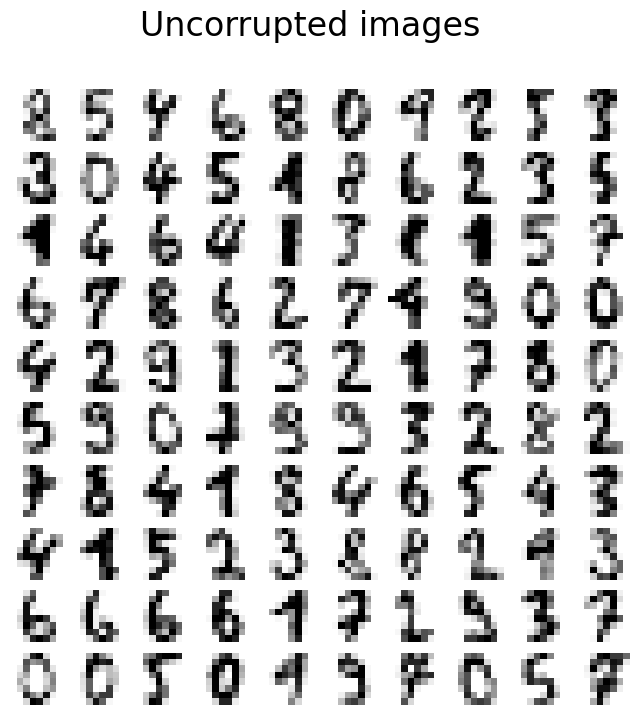

In [9]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((8, 8)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    
plot_digits(
    X_test_noisy, f"Corrupted images\n"
)

plot_digits(
    X_test,
    "Uncorrupted images",
)

#### Using PCA

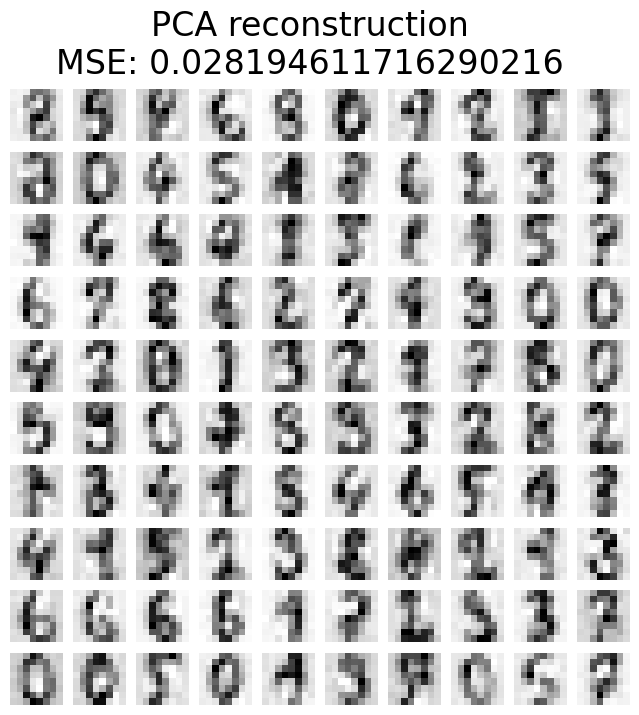

In [10]:
from sklearn.decomposition import PCA

# implement PCA here using the functions from sklearn
pca = PCA(n_components=14)
# fit the model
pca.fit(X_train_noisy)
# get the reconstruction
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))
# compute the loss
MSE_test = np.mean((X_test - X_reconstructed_pca) ** 2)

plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {MSE_test}",
)

#### Using an Autoencoder
Model definition.

In [11]:
from torch import nn
from torch import optim
import torch

# implement an MLP class in pytorch as a module to be used for the autoencoder components
# use ReLU activations

class MLP(nn.Module):
    def __init__(self, layer_io, activation = nn.ReLU() ):
        super(MLP,self).__init__()
        
        layers_list = []
        for i,o in layer_io:
            layers_list.extend([ nn.Linear(i,o), activation])
        
        self.sequence = nn.Sequential(*layers_list)
            
    def forward(self, x):
        return self.sequence(x)
    
# implement the autoencoder class
class Autoencoder(nn.Module):
    # implement the initialisation function
    def __init__(self, 
                latent_size=14,
                encoder_dims=[32,32],
                decoder_dims=[32,32],
                input_size=64,
                activation = nn.ReLU()
                ):
        super(Autoencoder,self).__init__()
        
        self.encoder = MLP(
            layer_io = zip([input_size]+encoder_dims, encoder_dims+[latent_size]),
            activation = activation)
        
        self.decoder = MLP(
            layer_io = zip([latent_size]+decoder_dims[:-1], decoder_dims),
            activation = activation)

        self.head = nn.Linear(decoder_dims[-1], input_size)

    # now implement the forward
    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.head(
            self.decoder(z))
        
        return reconstructed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
totensor = lambda x : torch.from_numpy(x).float().to(device)

/Users/chryssa/.pyenv/versions/3.10.6/envs/newcore/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We instantiate the model, creating the data tensor, sending it to the device, defining the loss function, and optimizer. 

In [12]:
# implement the train function 

def train(
    model,
    X_train_noisy,
    epochs=20000,
    lr=4e-3
):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    X_train = totensor(X_train_noisy)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs-1, eta_min=1e-8)
    
    criterion = nn.MSELoss()
    
    losses=[]

    model.train()

    # specify the steps for every epoch
    
    for epoch in range(epochs):
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(X_train)

        # compute training reconstruction loss
        train_loss = criterion(outputs, X_train)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()
        scheduler.step()
        # add the mini-batch training loss to epoch loss
        loss = train_loss.item()

        losses.append(loss)

    # display the epoch training loss
    
    return losses
    

In [13]:
def test(model,
        X_test_noisy,
        X_test):
    
    model.eval()
    with torch.no_grad():
        reconstructed_test_ae = model(totensor(X_test_noisy)).numpy()
        MSE_test = np.mean((X_test - reconstructed_test_ae) ** 2)

    plot_digits(
        reconstructed_test_ae,
        f"Autoencoder reconstruction\nMSE: {MSE_test}",
    )

#### Autoencoder with linear activation function.

Autoencoder(
  (encoder): MLP(
    (sequence): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Identity()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Identity()
      (4): Linear(in_features=32, out_features=14, bias=True)
      (5): Identity()
    )
  )
  (decoder): MLP(
    (sequence): Sequential(
      (0): Linear(in_features=14, out_features=32, bias=True)
      (1): Identity()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Identity()
    )
  )
  (head): Linear(in_features=32, out_features=64, bias=True)
)


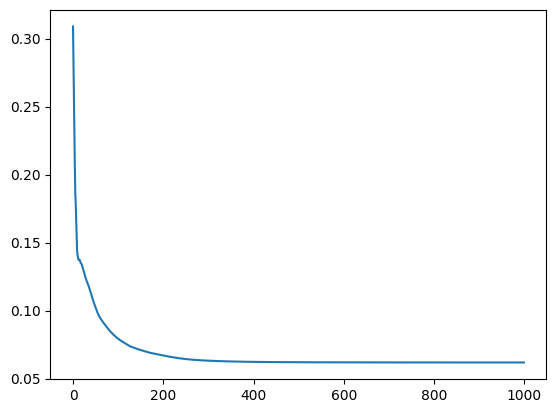

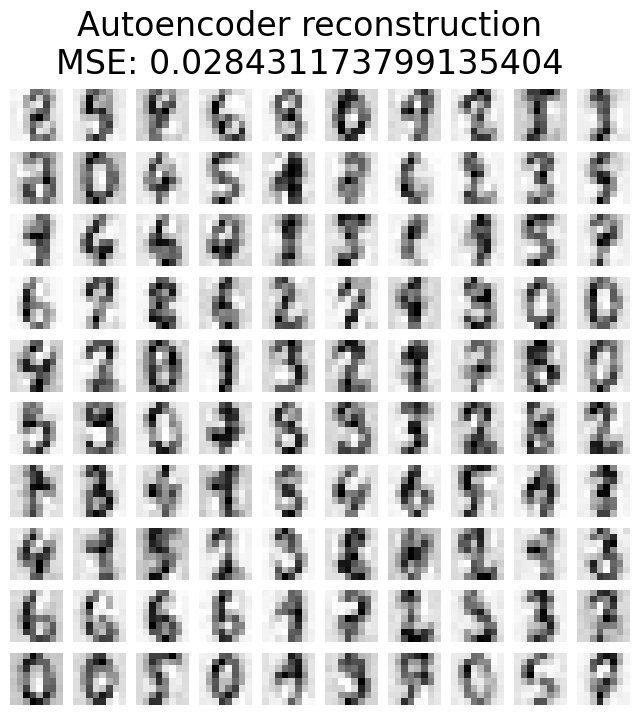

In [14]:
model = Autoencoder(
    latent_size=14,
    encoder_dims=[32,32],
    decoder_dims=[32,32],
    input_size=64,
    activation=nn.Identity()
)

print(model)

losses = train(
    model=model,
    X_train_noisy=X_train_noisy,
    epochs=1000,
    lr=4e-3
)

plt.plot(losses)

test(model,
    X_test_noisy,
    X_test)

#### Autoencoder with non-linear activation function.

Autoencoder(
  (encoder): MLP(
    (sequence): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=3, bias=True)
      (5): ReLU()
    )
  )
  (decoder): MLP(
    (sequence): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (head): Linear(in_features=32, out_features=64, bias=True)
)


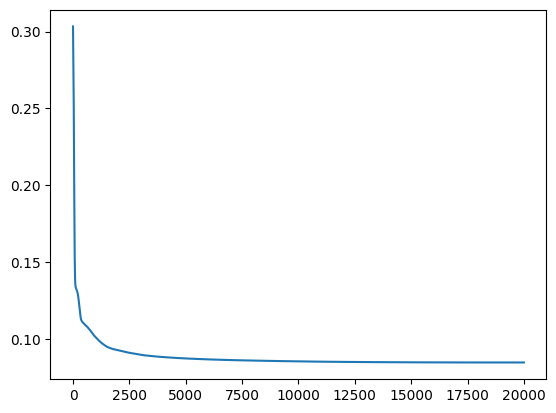

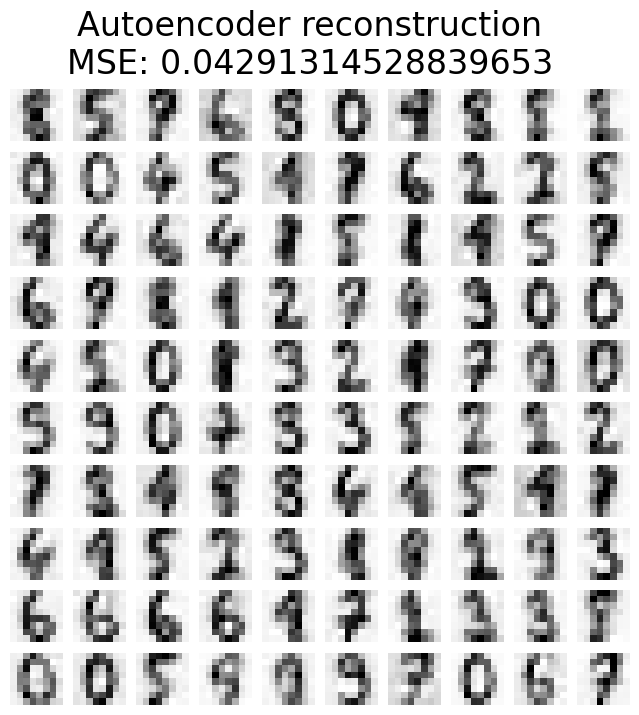

In [15]:
model = Autoencoder(
    latent_size=3,
    encoder_dims=[32,32],
    decoder_dims=[32,32],
    input_size=64,
    activation=nn.ReLU()
)

print(model)

losses = train(
    model=model,
    X_train_noisy=X_train_noisy,
    epochs=20000,
    lr=4e-4
)

plt.plot(losses)
plt.show()

test(model,
    X_test_noisy,
    X_test)

The size of the lower-dimensional subspace is significantly smaller with the autoencoder; however, the qualitative results are good. We encourage you to test different activation functions, number of epochs, bottleneck size, and network topology.

## Vizualizing the latent space

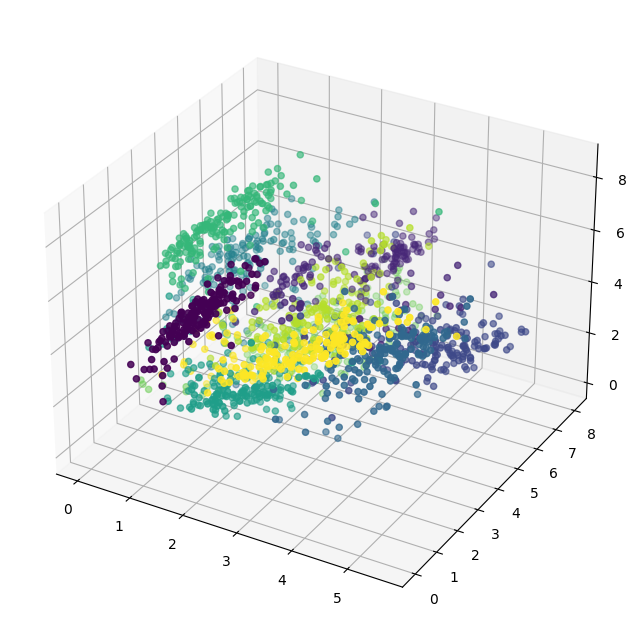

In [16]:
with torch.no_grad():
    latents = model.encoder(totensor(X_train)).numpy()
    
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter3D(latents[:,0],latents[:,1], latents[:,2], c=y_train);

Note that the latent space contains clusters pretaining to each of the class labels.